<a href="https://colab.research.google.com/github/olgaminguett/ET5003_SEM1_2021-2/blob/main/Week-5/ET5003_KaggleCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_KaggleCompetition

In [108]:
#@title Current Date
Today = "2021-10-06" #@param {type:"date"}

In [109]:
#@markdown ---
#@markdown ### Enter your details here:
Team_Number = "Group 1" #@param {type:"string"}
StudentID_Name = "20179766 - Olga Minguett" #@param {type:"string"}
StudentID_Name = "" #@param {type:"string"}
StudentID_Name = "" #@param {type:"string"}
StudentID_Name = "" #@param {type:"string"}
StudentID_Name = "" #@param {type:"string"}
#@markdown ---

In [110]:
#@title Notebook information
Notebook_type = 'Assignment' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

Your introduction here.

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [111]:
#!pip install GPy

In [112]:
# Regular expression operations
#https://docs.python.org/3/library/re.html
import re 

# standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn is an open source machine learning library 
# that supports supervised and unsupervised learning
# https://scikit-learn.org/stable/
# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

# Natural Language Toolkit
# https://www.nltk.org/install.html
import nltk

# Stemming maps different forms of the same word to a common “stem” 
# https://pypi.org/project/snowballstemmer/
from nltk.stem import SnowballStemmer

# https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords

import GPy as GPy
import pylab as pb
import pymc3 as pm
import arviz as az
from google.colab import files

# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [113]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Load Data

In [114]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
# Path, copy the path from your Drive
syntPath = '/content/drive/My Drive/Colab Notebooks/house-data/'

In [116]:
# House Data
house_train = syntPath + 'HousePrice_Train.csv'
house_test = syntPath + 'HousePrice_Test.csv'
sample_submission = syntPath + 'sample_submission.csv'

In [117]:
# Read datasets
house_train = pd.read_csv(house_train).drop(columns="ID")
house_test = pd.read_csv(house_test).drop(columns="ID")
sample_submission = pd.read_csv(sample_submission)

## Explore Data

In [118]:
print("Training data shape", house_train.shape)
print("Test data shape", house_test.shape)

Training data shape (1638, 13)
Test data shape (702, 12)


In [119]:
# Print sample rows of the dataframe
house_train.sample(3)

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
1336,1337,Terenure,2,3,D2,ON VIEW SATURDAY 7 TH MARCH 2020 11:30 AM - 12...,NaN,Charming three-bedroom family home\nMinutes aw...,53.310073,-6.325158,semi-detached,129.3,525000
865,866,Donaghmede,1,3,E1,DNG are delighted to present 119 Grange Abbey ...,Parking,Quiet &amp; Convenient location\nAttic convers...,53.397080,-6.154744,terraced,101.0,325000
1006,1007,Cabra,1,3,G,Property Team Lappin Estates take great pleasu...,"Parking,Gas Fired Central Heating",None,53.362782,-6.298107,semi-detached,76.0,325000


In [120]:
# Print sample rows of the dataframe
house_test.sample(3)

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface
55,1694,Cabra,1,2,E2,DNG are delighted to introduce number 175 St A...,NaN,None,53.367565,-6.285348,terraced,60.24
368,2007,Rathfarnham,1,2,C1,Located in the small gated development just of...,NaN,None,53.283376,-6.325654,apartment,51.00
199,1838,Crumlin,1,3,F,RESERVATION DEPOSIT RECEIVED\n\r\nThis is a ve...,"Parking,Gas Fired Central Heating",Spacious 3 bedroom house (66m2)\nExcellent con...,53.322471,-6.312063,semi-detached,66.00


In [121]:
#Returns column name
print('Train Data Columns',house_train.columns)
print(len(house_train.columns))
print('Test Data Columns',house_test.columns)
print(len(house_test.columns))

Train Data Columns Index(['Index', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Services', 'Features', 'Latitude', 'Longitude', 'Type',
       'Surface', 'Price'],
      dtype='object')
13
Test Data Columns Index(['Index', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Services', 'Features', 'Latitude', 'Longitude', 'Type',
       'Surface'],
      dtype='object')
12


In [122]:
print('Train Data Shape',house_train.shape)
print('Test Data Shape',house_test.shape)

Train Data Shape (1638, 13)
Test Data Shape (702, 12)


The data consists in two datasets, train and test House Data, with 1638 by 13 vs 702 by 12 respectively. Only difference in columns numbers is the Price, as in this case is our target predictor. Information provided by the features include location, number of bathrooms and beds, BER class, description of the property, services, lat and long, type of property, size through surface and price. A column ID was dropped at loading data stage as it is another property identifier, as well as Index, and the former is the one used to recognize properties in the sample submission file, reason why it was kept.

In [123]:
#Concise summary of the dataframe
print('Train Data Information')
house_train.info()

Train Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638 entries, 0 to 1637
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          1638 non-null   int64  
 1   Location       1638 non-null   object 
 2   Num_Bathrooms  1638 non-null   int64  
 3   Num_Beds       1638 non-null   int64  
 4   BER_class      1387 non-null   object 
 5   Description    1638 non-null   object 
 6   Services       577 non-null    object 
 7   Features       1638 non-null   object 
 8   Latitude       1638 non-null   float64
 9   Longitude      1638 non-null   float64
 10  Type           1638 non-null   object 
 11  Surface        1638 non-null   float64
 12  Price          1638 non-null   int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 166.5+ KB


In [124]:
#Concise summary of the dataframe
print('Test Data Information')
house_test.info()

Test Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          702 non-null    int64  
 1   Location       702 non-null    object 
 2   Num_Bathrooms  702 non-null    int64  
 3   Num_Beds       702 non-null    int64  
 4   BER_class      594 non-null    object 
 5   Description    702 non-null    object 
 6   Services       246 non-null    object 
 7   Features       702 non-null    object 
 8   Latitude       702 non-null    float64
 9   Longitude      702 non-null    float64
 10  Type           702 non-null    object 
 11  Surface        702 non-null    float64
dtypes: float64(3), int64(3), object(6)
memory usage: 65.9+ KB


In [125]:
# Descriptive Statistics
house_train.describe()

,Index,Num_Bathrooms,Num_Beds,Latitude,Longitude,Surface,Price
count,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1.638000e+03
mean,819.500000,2.054335,3.043346,53.350473,-6.255086,169.540695,5.547196e+05
std,472.994186,1.241259,1.379650,0.076832,0.144430,1791.793934,5.652032e+05
min,1.000000,1.000000,1.000000,52.501856,-6.497000,3.400000,1.999500e+04
25%,410.250000,1.000000,2.000000,53.294261,-6.309613,73.000000,2.950000e+05
50%,819.500000,2.000000,3.000000,53.341386,-6.247780,97.050000,3.950000e+05
75%,1228.750000,3.000000,4.000000,53.382031,-6.193982,135.000000,5.950000e+05
max,1638.000000,18.000000,27.000000,53.630588,-1.744995,72236.387140,8.900000e+06


In [126]:
# Descriptive Statistics
house_test.describe()

,Index,Num_Bathrooms,Num_Beds,Latitude,Longitude,Surface
count,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000
mean,1989.500000,2.027066,2.987179,53.350445,-6.252411,132.603530
std,202.794231,1.071273,1.198480,0.073961,0.091600,330.347066
min,1639.000000,1.000000,1.000000,53.214227,-6.521183,32.100000
25%,1814.250000,1.000000,2.000000,53.295225,-6.304258,73.000000
50%,1989.500000,2.000000,3.000000,53.341153,-6.247799,99.200000
75%,2164.750000,3.000000,4.000000,53.381752,-6.184277,136.875000
max,2340.000000,9.000000,14.000000,53.617443,-6.057150,8576.000000


In [127]:
# Missing Values
print('Train Data Missing Values')
print(house_train.isna().sum())

Train Data Missing Values
Index               0
Location            0
Num_Bathrooms       0
Num_Beds            0
BER_class         251
Description         0
Services         1061
Features            0
Latitude            0
Longitude           0
Type                0
Surface             0
Price               0
dtype: int64


In [128]:
print('Test Data Missing Values')
print(house_test.isna().sum())

Test Data Missing Values
Index              0
Location           0
Num_Bathrooms      0
Num_Beds           0
BER_class        108
Description        0
Services         456
Features           0
Latitude           0
Longitude          0
Type               0
Surface            0
dtype: int64


In [129]:
#Percentage of NAN Values
print('Train Data Percentage of NAN Values')
print(house_train.isna().mean().round(4) * 100)

Train Data Percentage of NAN Values
Index             0.00
Location          0.00
Num_Bathrooms     0.00
Num_Beds          0.00
BER_class        15.32
Description       0.00
Services         64.77
Features          0.00
Latitude          0.00
Longitude         0.00
Type              0.00
Surface           0.00
Price             0.00
dtype: float64


In [130]:
print('Test Data Percentage of NAN Values')
print(house_test.isna().mean().round(4) * 100)

Test Data Percentage of NAN Values
Index             0.00
Location          0.00
Num_Bathrooms     0.00
Num_Beds          0.00
BER_class        15.38
Description       0.00
Services         64.96
Features          0.00
Latitude          0.00
Longitude         0.00
Type              0.00
Surface           0.00
dtype: float64


In [131]:
# Recognise any columns that have the same value in each at the start of the code
# Feedback from Nigel Portley 
columnlist = []
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()

for column in house_train:
    if (is_unique(house_train[column]) == True): 
        print(column)
        columnlist.append(str(column))
print(columnlist)
#house_train.drop(columnlist, axis=1, inplace=True)

for column in house_test:
    if (is_unique(house_test[column]) == True): 
        print(column)
        columnlist.append(str(column))
print(columnlist)
#house_test.drop(columnlist, axis=1, inplace=True)

[]
[]


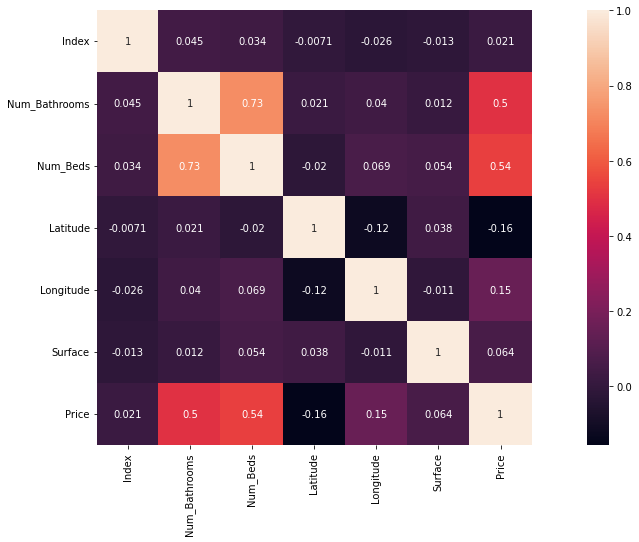

In [132]:
plt.figure(figsize=(20, 8))
sns.heatmap(house_train.corr(), square=True, annot=True);

For Missing Values, in the train dataset `BER_class` has 251 data points which represent ~15% and `Services` 1061 data points which is ~64%. In te other hand the test dataset `BER_class` has 108 data points which represent ~15% and `Services` 456 data points which is ~64%. Using part of the learnings from past etivity, none of the columns seem to have the same value. Futhermore, according to the Number of Bathrooms and Number of Beds, show the highest correlation of all of the features.

## Feature Engineering

'Index'

In [133]:
house_train['Index'].nunique()

1638

In [134]:
house_test['Index'].nunique()

702

Having 1638 and 702 unique values, corroborates Index as the property identifier, and one per property

'Location'

In [135]:
house_train['Location'].value_counts()

Castleknock    57
Malahide       50
Lucan          49
Rathfarnham    46
Clondalkin     41
               ..
Deansgrange     1
Ballymun        1
Park West       1
Coolmine        1
Oldbawn         1
Name: Location, Length: 142, dtype: int64

In [136]:
house_train['Location'].replace({'Temple Bar':'Dublin 1', 'IFSC':'Dublin 1', 
                            'Grand Canal Dock':'Dublin 2',
                            'Clontarf':'Dublin 3', 'East Wall':'Dublin 3', 'North Strand':'Dublin 3', 'Fairview':'Dublin 3', 'Marino':'Dublin 3', 'Ballyboughal':'Dublin 3', 
                            'Ballsbridge':'Dublin 4', 'Donnybrook':'Dublin 4','Sandymount':'Dublin 4','Ringsend':'Dublin 4','Irishtown':'Dublin 4','Merrion':'Dublin 4',
                            'Artane':'Dublin 5','Raheny':'Dublin 5','Kilbarrack':'Dublin 5','Edenmore':'Dublin 5','Kilmore':'Dublin 5','Donnycarney':'Dublin 5',
                            'Rathmines':'Dublin 6','Rathgar':'Dublin 6','Ranelagh':'Dublin 6','Milltown':'Dublin 6','Dartry':'Dublin 6',
                            'Stoneybatter':'Dublin 7','Phibsborough':'Dublin 7','Navan Road (D7)':'Dublin 7','North Circular Road':'Dublin 7','Smithfield':'Dublin 7','Ashtown':'Dublin 7','Cabra':'Dublin 7',
                            'Kilmainham':'Dublin 8','Inchicore':'Dublin 8','Rialto':'Dublin 8','Portobello':'Dublin 8','South Circular Road':'Dublin 8','Islandbridge':'Dublin 8','The Coombe':'Dublin 8',"Dolphin's Barn":'Dublin 8','Christchurch':'Dublin 8',
                            'Drumcondra':'Dublin 9','Glasnevin':'Dublin 9','Santry':'Dublin 9','Whitehall':'Dublin 9','Beaumont':'Dublin 9','Ballymun':'Dublin 9','Poppintree':'Dublin 9',
                            'Ballyfermot':'Dublin 10','Cherry Orchard':'Dublin 10',
                            'Finglas':'Dublin 11',"St Margaret's":'Dublin 11',
                            'Walkinstown':'Dublin 12','Crumlin':'Dublin 12','Drimnagh':'Dublin 12','Bluebell':'Dublin 12','Park West':'Dublin 12','Perrystown':'Dublin 12',
                            'Malahide':'Dublin 13','Howth':'Dublin 13','Sutton':'Dublin 13','Baldoyle':'Dublin 13','Donaghmede':'Dublin 13','Bayside':'Dublin 13','Ard Na Greine':'Dublin 13','Clongriffin':'Dublin 13','Clarehall':'Dublin 13',
                            'Dundrum':'Dublin 14','Churchtown':'Dublin 14','Goatstown':'Dublin 14','Clonskeagh':'Dublin 14','Windy Arbour':'Dublin 14',
                            'Carpenterstown':'Dublin 15','Castleknock':'Dublin 15','Clonsilla':'Dublin 15','Blanchardstown':'Dublin 15','Clonee':'Dublin 15','Coolmine':'Dublin 15','Hartstown':'Dublin 15','Mulhuddart':'Dublin 15','The Ward':'Dublin 15','Ongar':'Dublin 15','Tyrrelstown':'Dublin 15',
                            'Rathfarnham':'Dublin 16','Ballinteer':'Dublin 16','Ballinascorney':'Dublin 16','Knocklyon':'Dublin 16',
                            'Darndale':'Dublin 17','Clonshaugh':'Dublin 17','Coolock':'Dublin 17','Killester':'Dublin 17',
                            'Deansgrange':'Dublin 18','Sandyford':'Dublin 18','Foxrock':'Dublin 18','Stepaside':'Dublin 18','Cabinteely':'Dublin 18','Carrickmines':'Dublin 18','Leopardstown':'Dublin 18','Kilternan':'Dublin 18','Shankill':'Dublin 18',
                            'Palmerstown':'Dublin 20','Chapelizod':'Dublin 20','Lucan':'Dublin 20',
                            'Clondalkin':'Dublin 22','Kingswood':'Dublin 22','Newcastle':'Dublin 22',
                            'Ballymount':'Dublin 24','Kiltipper':'Dublin 24','Tallaght':'Dublin 24','Balrothery':'Dublin 24','Rathcoole':'Dublin 24','Kilnamanagh':'Dublin 24','Firhouse':'Dublin 24','Greenhills':'Dublin 24','Oldbawn':'Dublin 24','Adamstown':'Dublin 24','Saggart':'Dublin 24','Citywest':'Dublin 24','Ballycullen':'Dublin 24','Brittas':'Dublin 24',
                            'Terenure':'Dublin 6w',"Harold's Cross":'Dublin 6w','Kimmage':'Dublin 6w','Templeogue':'Dublin 6w',
                            'Donabate':'Fingal','Swords':'Fingal','Portmarnock':'Fingal','Kinsealy':'Fingal','Balgriffin':'Fingal','Garristown':'Fingal','Naul':'Fingal','Skerries':'Fingal','Rush':'Fingal','Lusk':'Fingal','Balbriggan':'Fingal','Loughshinny':'Fingal','Ballybough':'Fingal',
                            'Blackrock':'DunLaoghaireRathdown','Dun Laoghaire':'DunLaoghaireRathdown','Glenageary':'DunLaoghaireRathdown',
                            'Monkstown':'DunLaoghaireRathdown','Booterstown':'DunLaoghaireRathdown','Sandycove':'DunLaoghaireRathdown',
                            'Rathmichael':'DunLaoghaireRathdown','Mount Merrion':'DunLaoghaireRathdown','Ballybrack':'DunLaoghaireRathdown','Sallynoggin':'DunLaoghaireRathdown',
                            'Kilmacud':'DunLaoghaireRathdown','Dalkey':'DunLaoghaireRathdown','Killiney':'DunLaoghaireRathdown','Loughlinstown':'DunLaoghaireRathdown',
                            }, inplace=True)

In [137]:
house_train['Location'].value_counts()

DunLaoghaireRathdown    160
Fingal                  139
Dublin 15               117
Dublin 13               115
Dublin 24               104
Dublin 9                 97
Dublin 18                96
Dublin 4                 95
Dublin 16                80
Dublin 7                 69
Dublin 8                 65
Dublin 20                58
Dublin 6                 56
Dublin 14                55
Dublin 3                 55
Dublin 6w                48
Dublin 22                43
Dublin 5                 42
Dublin 1                 38
Dublin 11                32
Dublin 12                29
Dublin 2                 24
Dublin 17                17
Dublin 10                 4
Name: Location, dtype: int64

In [138]:
house_test['Location'].replace({'Temple Bar':'Dublin 1', 'IFSC':'Dublin 1', 
                            'Grand Canal Dock':'Dublin 2',
                            'Clontarf':'Dublin 3', 'East Wall':'Dublin 3', 'North Strand':'Dublin 3', 'Fairview':'Dublin 3', 'Marino':'Dublin 3', 'Ballyboughal':'Dublin 3', 
                            'Ballsbridge':'Dublin 4', 'Donnybrook':'Dublin 4','Sandymount':'Dublin 4','Ringsend':'Dublin 4','Irishtown':'Dublin 4','Merrion':'Dublin 4',
                            'Artane':'Dublin 5','Raheny':'Dublin 5','Kilbarrack':'Dublin 5','Edenmore':'Dublin 5','Kilmore':'Dublin 5','Donnycarney':'Dublin 5',
                            'Rathmines':'Dublin 6','Rathgar':'Dublin 6','Ranelagh':'Dublin 6','Milltown':'Dublin 6','Dartry':'Dublin 6',
                            'Stoneybatter':'Dublin 7','Phibsborough':'Dublin 7','Navan Road (D7)':'Dublin 7','North Circular Road':'Dublin 7','Smithfield':'Dublin 7','Ashtown':'Dublin 7','Cabra':'Dublin 7',
                            'Kilmainham':'Dublin 8','Inchicore':'Dublin 8','Rialto':'Dublin 8','Portobello':'Dublin 8','South Circular Road':'Dublin 8','Islandbridge':'Dublin 8','The Coombe':'Dublin 8',"Dolphin's Barn":'Dublin 8','Christchurch':'Dublin 8',
                            'Drumcondra':'Dublin 9','Glasnevin':'Dublin 9','Santry':'Dublin 9','Whitehall':'Dublin 9','Beaumont':'Dublin 9','Ballymun':'Dublin 9','Poppintree':'Dublin 9',
                            'Ballyfermot':'Dublin 10','Cherry Orchard':'Dublin 10',
                            'Finglas':'Dublin 11',"St Margaret's":'Dublin 11',
                            'Walkinstown':'Dublin 12','Crumlin':'Dublin 12','Drimnagh':'Dublin 12','Bluebell':'Dublin 12','Park West':'Dublin 12','Perrystown':'Dublin 12',
                            'Malahide':'Dublin 13','Howth':'Dublin 13','Sutton':'Dublin 13','Baldoyle':'Dublin 13','Donaghmede':'Dublin 13','Bayside':'Dublin 13','Ard Na Greine':'Dublin 13','Clongriffin':'Dublin 13','Clarehall':'Dublin 13',
                            'Dundrum':'Dublin 14','Churchtown':'Dublin 14','Goatstown':'Dublin 14','Clonskeagh':'Dublin 14','Windy Arbour':'Dublin 14',
                            'Carpenterstown':'Dublin 15','Castleknock':'Dublin 15','Clonsilla':'Dublin 15','Blanchardstown':'Dublin 15','Clonee':'Dublin 15','Coolmine':'Dublin 15','Hartstown':'Dublin 15','Mulhuddart':'Dublin 15','The Ward':'Dublin 15','Ongar':'Dublin 15','Tyrrelstown':'Dublin 15',
                            'Rathfarnham':'Dublin 16','Ballinteer':'Dublin 16','Ballinascorney':'Dublin 16','Knocklyon':'Dublin 16',
                            'Darndale':'Dublin 17','Clonshaugh':'Dublin 17','Coolock':'Dublin 17','Killester':'Dublin 17',
                            'Deansgrange':'Dublin 18','Sandyford':'Dublin 18','Foxrock':'Dublin 18','Stepaside':'Dublin 18','Cabinteely':'Dublin 18','Carrickmines':'Dublin 18','Leopardstown':'Dublin 18','Kilternan':'Dublin 18','Shankill':'Dublin 18',
                            'Palmerstown':'Dublin 20','Chapelizod':'Dublin 20','Lucan':'Dublin 20',
                            'Clondalkin':'Dublin 22','Kingswood':'Dublin 22','Newcastle':'Dublin 22',
                            'Ballymount':'Dublin 24','Kiltipper':'Dublin 24','Tallaght':'Dublin 24','Balrothery':'Dublin 24','Rathcoole':'Dublin 24','Kilnamanagh':'Dublin 24','Firhouse':'Dublin 24','Greenhills':'Dublin 24','Oldbawn':'Dublin 24','Adamstown':'Dublin 24','Saggart':'Dublin 24','Citywest':'Dublin 24','Ballycullen':'Dublin 24','Brittas':'Dublin 24',
                            'Terenure':'Dublin 6w',"Harold's Cross":'Dublin 6w','Kimmage':'Dublin 6w','Templeogue':'Dublin 6w',
                            'Donabate':'Fingal','Swords':'Fingal','Portmarnock':'Fingal','Kinsealy':'Fingal','Balgriffin':'Fingal','Garristown':'Fingal','Naul':'Fingal','Skerries':'Fingal','Rush':'Fingal','Lusk':'Fingal','Balbriggan':'Fingal','Loughshinny':'Fingal','Ballybough':'Fingal',
                            'Blackrock':'DunLaoghaireRathdown','Dun Laoghaire':'DunLaoghaireRathdown','Glenageary':'DunLaoghaireRathdown',
                            'Monkstown':'DunLaoghaireRathdown','Booterstown':'DunLaoghaireRathdown','Sandycove':'DunLaoghaireRathdown',
                            'Rathmichael':'DunLaoghaireRathdown','Mount Merrion':'DunLaoghaireRathdown','Ballybrack':'DunLaoghaireRathdown','Sallynoggin':'DunLaoghaireRathdown',
                            'Kilmacud':'DunLaoghaireRathdown','Dalkey':'DunLaoghaireRathdown','Killiney':'DunLaoghaireRathdown','Loughlinstown':'DunLaoghaireRathdown',
                            }, inplace=True)

In [139]:
house_test['Location'].value_counts()

DunLaoghaireRathdown    73
Fingal                  67
Dublin 13               44
Dublin 18               43
Dublin 9                43
Dublin 8                41
Dublin 15               40
Dublin 4                40
Dublin 16               37
Dublin 24               32
Dublin 7                29
Dublin 20               25
Dublin 3                22
Dublin 6w               21
Dublin 1                21
Dublin 12               20
Dublin 14               20
Dublin 5                17
Dublin 6                16
Dublin 22               16
Dublin 11               14
Dublin 2                10
Dublin 17                7
Dublin 10                4
Name: Location, dtype: int64

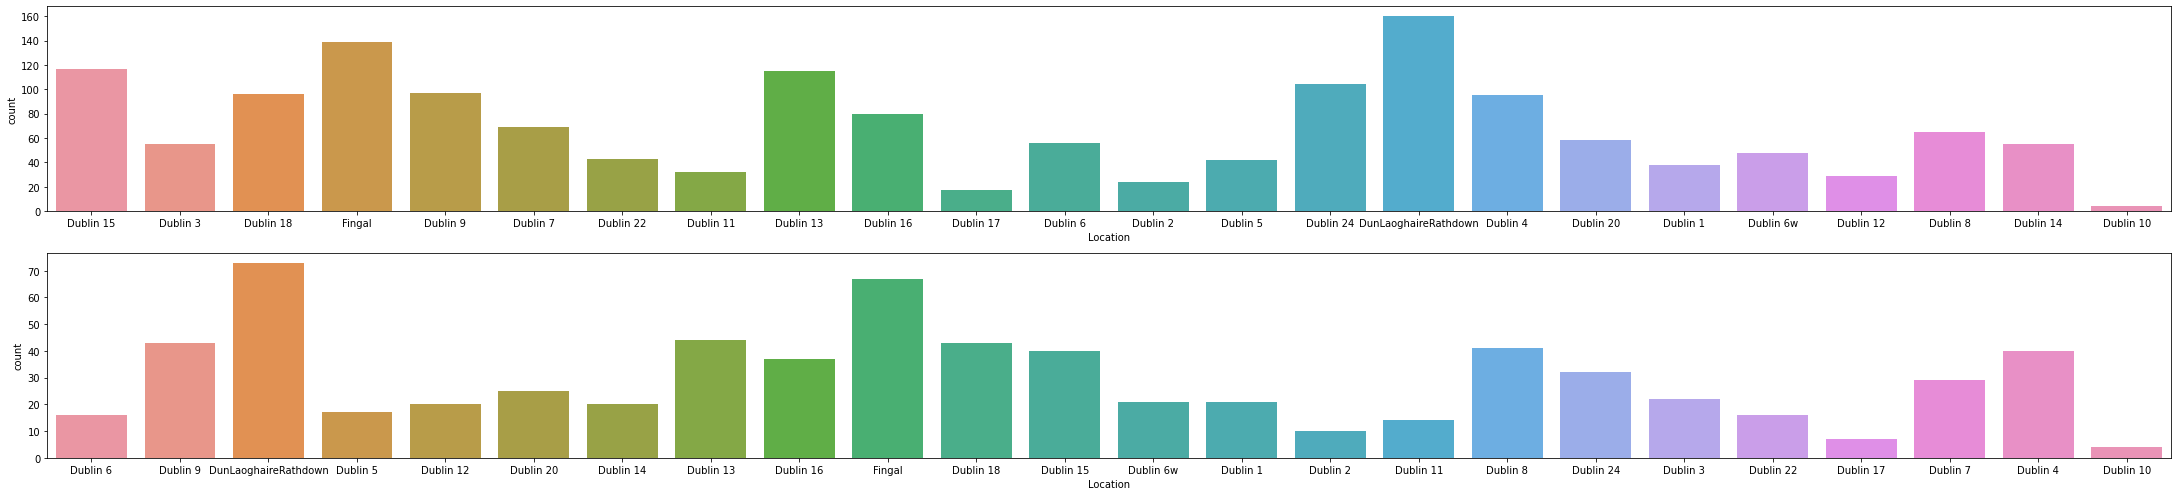

In [140]:
fig = plt.figure(figsize=(60,7))
fig.add_subplot(2,2,1)
sns.countplot(house_train['Location'])
fig.add_subplot(2,2,3)
sns.countplot(house_test['Location'])
plt.tight_layout()

In [141]:
# Get one hot encoding of columns area
one_hot = pd.get_dummies(house_train['Location'])
one_hot_ = pd.get_dummies(house_test['Location'])
# Drop column Area as it is now encoded
house_test = house_test.drop('Location', axis=1)
house_train = house_train.drop('Location', axis=1)
# Join the encoded dataframe
house_train = house_train.join(one_hot)
house_test = house_test.join(one_hot_)

Using learning from the past etivity, Location was converted to numerical variables, replacing all characters, from various cities and towns in County Dublin, County Fingal and County Dun Laoghaire-Rathdown to the various Dublin and Counties that they are located. Being Dun Laoghaire and Fingal, the ones with the highest number of properties, follow by Dublin 9, 13 and 24 for the train dataset and 9, 13, and 18. Two from the Nort section of the city and one from the south side in each case. Followed by to a reconfiguration to the correspondent numerical value, when using get_dummies.

'Num_Bathrooms'

In [142]:
house_train['Num_Bathrooms'].value_counts()

1     603
2     584
3     327
4      76
5      24
6      11
7       6
8       3
15      2
18      1
9       1
Name: Num_Bathrooms, dtype: int64

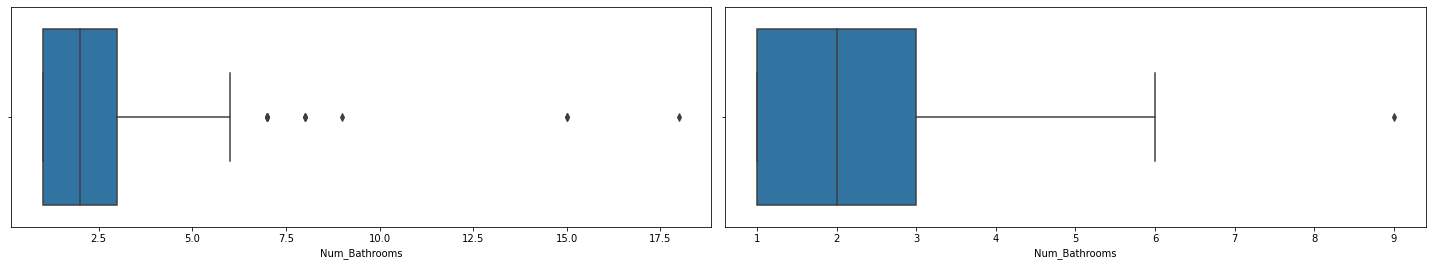

In [143]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(2,2,1)
sns.boxplot(x=house_train["Num_Bathrooms"])
fig.add_subplot(2,2,2)
sns.boxplot(x=house_test["Num_Bathrooms"])
plt.tight_layout()

In [144]:
house_train['Num_Bathrooms'].values[house_train['Num_Bathrooms'].values > 6 ] = 6
house_test['Num_Bathrooms'].values[house_test['Num_Bathrooms'].values > 6 ] = 6

Number of bathrooms was reconfigured to remove the outliers, having all a max of 6 bathrooms per property, having 1 as minimun.

'Num_Beds'

In [145]:
house_train['Num_Beds'].value_counts()

3     558
2     464
4     348
1     114
5     107
6      29
7      11
15      2
9       2
8       2
27      1
Name: Num_Beds, dtype: int64

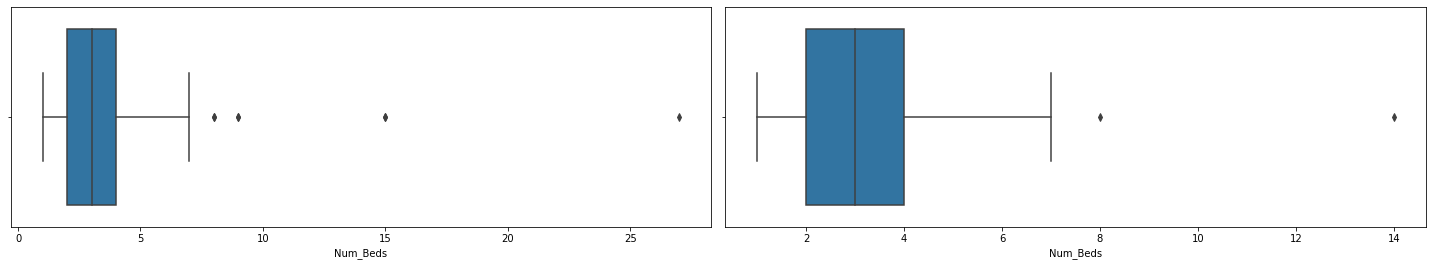

In [146]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(2,2,1)
sns.boxplot(x=house_train["Num_Beds"])
fig.add_subplot(2,2,2)
sns.boxplot(x=house_test["Num_Beds"])
plt.tight_layout()

In [147]:
house_train['Num_Beds'].values[house_train['Num_Beds'].values > 7 ] = 7
house_test['Num_Beds'].values[house_test['Num_Beds'].values > 7 ] = 7

Number of beds was reconfigured to remove the outliers, having all a max of 7 beds per property, having 1 as minimun.

'BER_class'

In [148]:
house_train['BER_class'].value_counts()

D1                     182
D2                     173
C3                     154
C2                     144
C1                     133
E1                     110
G                      103
E2                     101
F                       89
B3                      78
B2                      48
A3                      37
SINo666of2006exempt     15
A2                      12
B1                       7
A1                       1
Name: BER_class, dtype: int64

In [149]:
print("Train Dataset Missing Data:",house_train['BER_class'].isna().sum())
print("Test Dataset Missing Data:", house_test['BER_class'].isna().sum())

Train Dataset Missing Data: 251
Test Dataset Missing Data: 108


In [150]:
house_train['BER_class'].fillna('unknown', inplace=True)
house_test['BER_class'].fillna('unknown', inplace=True)

In [151]:
ber_classification_mapper = {
    "A1": 1,
    "A2": 2,
    "A3": 3,
    "B1": 4,
    "B2": 5,
    "B3": 6,
    "C1": 7,
    "C2": 8,
    "C3": 9,
    "D1": 10,
    "D2": 11,
    "E1": 12,
    "E2": 13,
    "F": 14,
    "G": 15,
    "SINo666of2006exempt": 16,
    "unknown": 17
}
house_train['BER_class'] = house_train['BER_class'].replace(ber_classification_mapper)
house_test['BER_class'] = house_test['BER_class'].replace(ber_classification_mapper)

`BER_classification` contained ~15% of missing values that were filled up with Unknown, as they represent a significant amount that can modify other categories within it. They were converted to numerical variables, replacing the 17 characters.

'Description'

In [152]:
house_train['Description'].head()

0    DNG are delighted to present to the market no....
1    13 Northbrook Terrace is a charming red brick ...
2    Welcome to No. 6 Cotter Close, an immaculately...
3    Welcome to 3 Sycamore Walk!\n\r\nEnjoying a pr...
4    'Four Seasons' comes to the market as a wonder...
Name: Description, dtype: object

`Description` is Free text, that will be processed using NLP

'Services'

In [153]:
house_train['Services'].value_counts()

Parking,Gas Fired Central Heating                                                               118
Parking                                                                                          77
Parking,Gas Fired Central Heating,Wired for Cable Television                                     74
Parking,Gas Fired Central Heating,Alarm,Wired for Cable Television                               62
Parking,Gas Fired Central Heating,Alarm                                                          57
Parking,Wired for Cable Television                                                               35
Gas Fired Central Heating                                                                        25
Parking,Alarm                                                                                    12
Parking,Gas Fired Central Heating,Alarm,Wired for Cable Television,Wheelchair Access             12
Parking,Oil Fired Central Heating                                                                12


In [154]:
house_train["Alarm"] = house_train["Services"].str.contains("Alarm").fillna("No")
house_train["Alarm"].replace({True : "Yes", False : "No"}, inplace=True)
alarm_mapper = {"Yes": 0,"No": 1}
house_train['Alarm'] = house_train['Alarm'].replace(alarm_mapper)

house_train["GasFiredCentralHeating"] = house_train["Services"].str.contains("Gas Fired Central Heating").fillna("No")
house_train["GasFiredCentralHeating"].replace({True : "Yes", False : "No"}, inplace=True)
GasFiredCentralHeating_mapper = {"Yes": 0,"No": 1}
house_train['GasFiredCentralHeating'] = house_train['GasFiredCentralHeating'].replace(GasFiredCentralHeating_mapper)

house_train["Parking"] = house_train["Services"].str.contains("Parking").fillna("No")
house_train["Parking"].replace({True : "Yes", False : "No"}, inplace=True)
parking_mapper = {"Yes": 0,"No": 1}
house_train['Parking'] = house_train['Parking'].replace(parking_mapper)

house_train["OilFiredCentralHeating"] = house_train["Services"].str.contains("Oil Fired Central Heating").fillna("No")
house_train["OilFiredCentralHeating"].replace({True : "Yes", False : "No"}, inplace=True)
OilFiredCentralHeating_mapper = {"Yes": 0,"No": 1}
house_train['OilFiredCentralHeating'] = house_train['OilFiredCentralHeating'].replace(OilFiredCentralHeating_mapper)

house_train["WheelchairAccess"] = house_train["Services"].str.contains("Wheelchair Access").fillna("No")
house_train["WheelchairAccess"].replace({True : "Yes", False : "No"}, inplace=True)
WheelchairAccess_mapper = {"Yes": 0,"No": 1}
house_train['WheelchairAccess'] = house_train['WheelchairAccess'].replace(WheelchairAccess_mapper)

house_train["WiredForCableTelevision"] = house_train["Services"].str.contains("Wired for Cable Television").fillna("No")
house_train["WiredForCableTelevision"].replace({True : "Yes", False : "No"}, inplace=True)
WiredForCableTelevision_mapper = {"Yes": 0,"No": 1}
house_train['WiredForCableTelevision'] = house_train['WiredForCableTelevision'].replace(WiredForCableTelevision_mapper)

In [155]:
house_test["Alarm"] = house_test["Services"].str.contains("Alarm").fillna("No")
house_test["Alarm"].replace({True : "Yes", False : "No"}, inplace=True)
alarm_mapper = {"Yes": 0,"No": 1}
house_test['Alarm'] = house_test['Alarm'].replace(alarm_mapper)

house_test["GasFiredCentralHeating"] = house_test["Services"].str.contains("Gas Fired Central Heating").fillna("No")
house_test["GasFiredCentralHeating"].replace({True : "Yes", False : "No"}, inplace=True)
GasFiredCentralHeating_mapper = {"Yes": 0,"No": 1}
house_test['GasFiredCentralHeating'] = house_test['GasFiredCentralHeating'].replace(GasFiredCentralHeating_mapper)

house_test["Parking"] = house_test["Services"].str.contains("Parking").fillna("No")
house_test["Parking"].replace({True : "Yes", False : "No"}, inplace=True)
parking_mapper = {"Yes": 0,"No": 1}
house_test['Parking'] = house_test['Parking'].replace(parking_mapper)

house_test["OilFiredCentralHeating"] = house_test["Services"].str.contains("Oil Fired Central Heating").fillna("No")
house_test["OilFiredCentralHeating"].replace({True : "Yes", False : "No"}, inplace=True)
OilFiredCentralHeating_mapper = {"Yes": 0,"No": 1}
house_test['OilFiredCentralHeating'] = house_test['OilFiredCentralHeating'].replace(OilFiredCentralHeating_mapper)

house_test["WheelchairAccess"] = house_test["Services"].str.contains("Wheelchair Access").fillna("No")
house_test["WheelchairAccess"].replace({True : "Yes", False : "No"}, inplace=True)
WheelchairAccess_mapper = {"Yes": 0,"No": 1}
house_test['WheelchairAccess'] = house_test['WheelchairAccess'].replace(WheelchairAccess_mapper)

house_test["WiredForCableTelevision"] = house_test["Services"].str.contains("Wired for Cable Television").fillna("No")
house_test["WiredForCableTelevision"].replace({True : "Yes", False : "No"}, inplace=True)
WiredForCableTelevision_mapper = {"Yes": 0,"No": 1}
house_test['WiredForCableTelevision'] = house_test['WiredForCableTelevision'].replace(WiredForCableTelevision_mapper)

In [156]:
services = ['Alarm', 'GasFiredCentralHeating', 'Parking', 'OilFiredCentralHeating', 'WheelchairAccess', 'WiredForCableTelevision']
for i in services:
  print(house_train[i].value_counts())

1    1442
0     196
Name: Alarm, dtype: int64
1    1259
0     379
Name: GasFiredCentralHeating, dtype: int64
1    1123
0     515
Name: Parking, dtype: int64
1    1595
0      43
Name: OilFiredCentralHeating, dtype: int64
1    1603
0      35
Name: WheelchairAccess, dtype: int64
1    1393
0     245
Name: WiredForCableTelevision, dtype: int64


In [157]:
house_train[['Alarm', 'GasFiredCentralHeating', 'Parking', 'OilFiredCentralHeating', 'WheelchairAccess', 'WiredForCableTelevision']].head()

,Alarm,GasFiredCentralHeating,Parking,OilFiredCentralHeating,WheelchairAccess,WiredForCableTelevision
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1


In [158]:
house_train.drop('Services', axis=1, inplace=True)
house_test.drop('Services', axis=1, inplace=True)

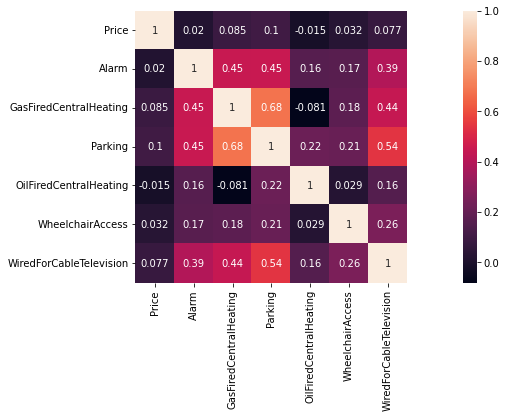

In [159]:
plt.figure(figsize=(20,5))
sns.heatmap(house_train[['Price','Alarm', 'GasFiredCentralHeating', 'Parking', 'OilFiredCentralHeating', 'WheelchairAccess', 'WiredForCableTelevision']].corr(), square=True, annot=True);

The `Services` feature contains information about particular amenities or facilities available in every property, described as follow:
- Alarm
- GasFiredCentralHeating
- Parking
- OilFiredCentralHeating
- WheelchairAccess
- WiredForCableTelevision

They were preprocessed finding the correspondent service in the available information, to then adding a `Yes` or `No` to that service in the property. Next, they were mapped to its numerical value. Having in mind that ~64% of the data point are missing, this process removes them filling them with 0 to represent the no information about this value. Considering dropping variable, as even after preprocessing doesn't bring significant value to the evaluation. But very interesting to notice how Parking, Gas Fired Central Heating and Alarm are correlated to Price modifying it, maybe dropping OilFiredCentralHeating, WheelchairAccess and WiredForCableTelevision instead.



'Features' 

In [160]:
house_train['Features'].head()

0                                                 None
1    Bight and Spacious interior\nNumerous original...
2    Special Features\nLarge rear garden\nGenerous ...
3    Wonderful 3 bed detached bungalow.     \nAccom...
4    Detached Property      \nDouble Glazed Windows...
Name: Features, dtype: object

`Features` is Free text, that will be processed using NLP

'Latitude' & 'Longitude'

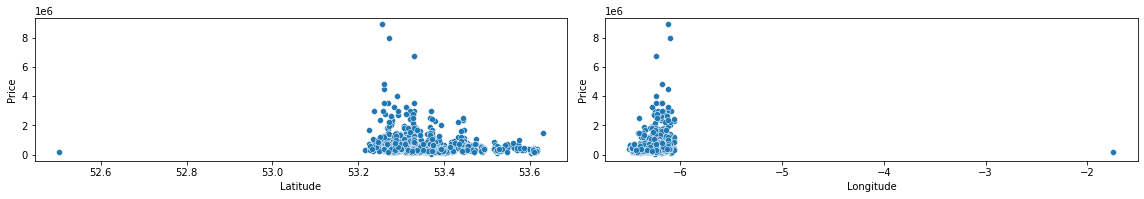

In [161]:
fig = plt.figure(figsize=(16,5))
fig.add_subplot(2,2,1)
sns.scatterplot(house_train['Latitude'],house_train['Price'])
fig.add_subplot(2,2,2)
sns.scatterplot(house_train['Longitude'],house_train['Price'])
plt.tight_layout()

In [162]:
# Removing location that are outside of Ireland 
house_train = house_train.drop(house_train[house_train['Latitude'] < 52].index)
house_train = house_train.drop(house_train[house_train['Longitude'] > -5].index)

house_test = house_test.drop(house_test[house_test['Latitude'] < 52].index)
house_test = house_test.drop(house_test[house_test['Longitude'] > -5].index)

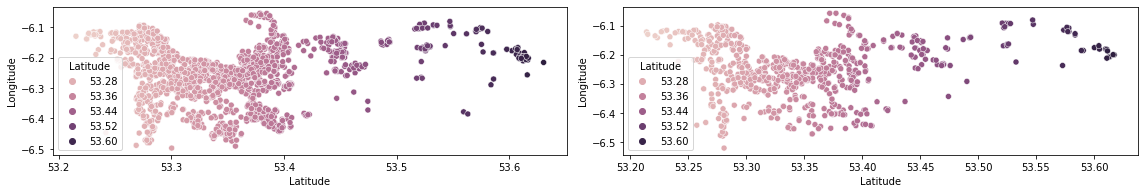

In [163]:
fig = plt.figure(figsize=(16,5))
fig.add_subplot(2,2,1)
sns.scatterplot(data=house_train,x='Latitude', y='Longitude', hue='Latitude')
fig.add_subplot(2,2,2)
sns.scatterplot(data=house_test,x='Latitude', y='Longitude', hue='Latitude')
plt.tight_layout()

For `Latitude` and `Longitude` we can see an outlier, dropped by removing data points < 52 and lower -5.

'Type'

In [164]:
house_train['Type'].value_counts()

semi-detached     457
apartment         431
terraced          299
detached          234
end-of-terrace    118
bungalow           48
duplex             33
townhouse          14
studio              2
site                1
Name: Type, dtype: int64

In [165]:
# Get one hot encoding of columns area
one_hot = pd.get_dummies(house_train['Type'])
one_hot_ = pd.get_dummies(house_test['Type'])
# Drop column property type as it is now encoded
house_test = house_test.drop('Type', axis=1)
house_train = house_train.drop('Type', axis=1)
# Join the encoded dataframe
house_train = house_train.join(one_hot)
house_test = house_test.join(one_hot_)

Property Type was converted to numerical variables, replacing the 10 characters 
using get_dummies

'Surface'

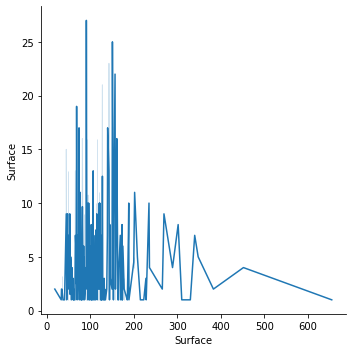

In [166]:
surface_counts = house_train['Surface'].value_counts()
sns.relplot(data=house_train, kind="line", x="Surface", y=surface_counts, facet_kws=dict(sharex=False));

In [167]:
house_train['Surface'].values[house_train['Surface'].values > 350] = 353
house_test['Surface'].values[house_test['Surface'].values > 350] = 350

`Surface` was reconfigured to remove the outliers, having all a max of 350 sqm per property

'Price'

In [168]:
## Log transform target
house_train['Price'] = np.log(house_train['Price'])

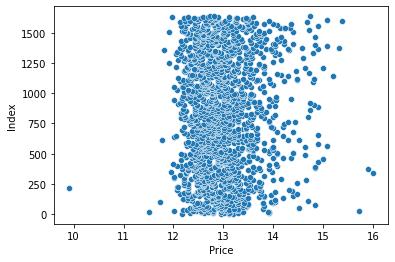

In [169]:
sns.scatterplot(data=house_train,x='Price', y='Index');

<Figure size 1440x2520 with 0 Axes>

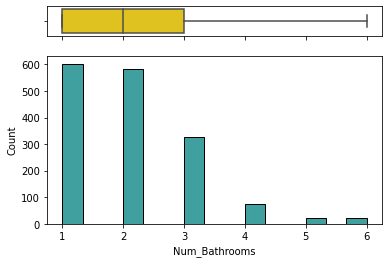

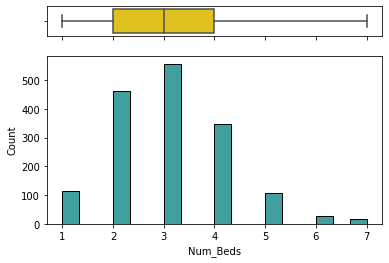

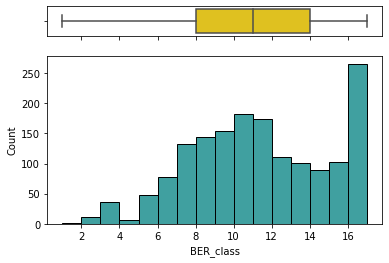

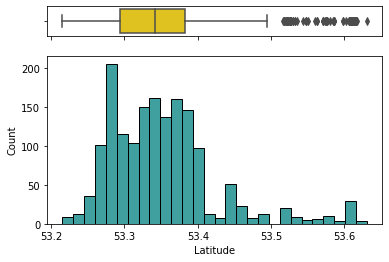

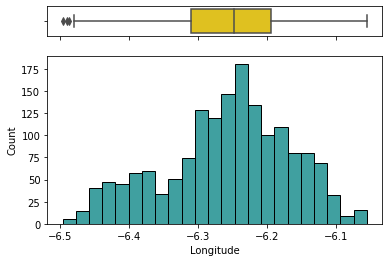

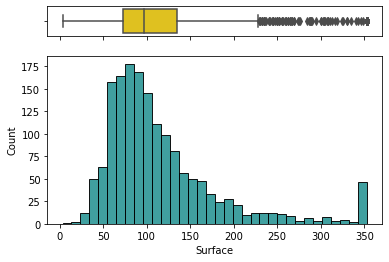

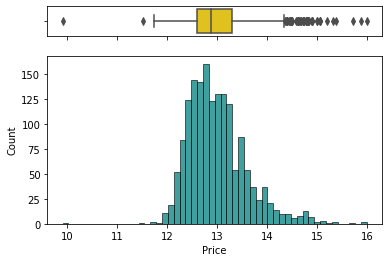

In [170]:
# Representation of the summary of the set of data values 
features = ['Num_Bathrooms', 'Num_Beds', 'BER_class', 'Latitude', 'Longitude', 'Surface', 'Price']
fig = plt.figure(figsize=(20,(len(features))*5))
sns.color_palette("viridis", as_cmap=True)
for i in features: 
  # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
  f, (ax_box, ax_hist) = plt.subplots(2,1, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
  
  # assigning a graph to each ax
  sns.boxplot(house_train[i], ax=ax_box, color="gold")
  sns.histplot(data=house_train, x=i, ax=ax_hist, color="teal")
  
  # Remove x axis name for the boxplot
  ax_box.set(xlabel='')

plt.show();

In [171]:
# Missing Values
print('Train Data Missing Values')
print(house_train.isna().sum())
print('')
print('Test Data Missing Values')
print(house_test.isna().sum())

Train Data Missing Values
Index                      0
Num_Bathrooms              0
Num_Beds                   0
BER_class                  0
Description                0
Features                   0
Latitude                   0
Longitude                  0
Surface                    0
Price                      0
Dublin 1                   0
Dublin 10                  0
Dublin 11                  0
Dublin 12                  0
Dublin 13                  0
Dublin 14                  0
Dublin 15                  0
Dublin 16                  0
Dublin 17                  0
Dublin 18                  0
Dublin 2                   0
Dublin 20                  0
Dublin 22                  0
Dublin 24                  0
Dublin 3                   0
Dublin 4                   0
Dublin 5                   0
Dublin 6                   0
Dublin 6w                  0
Dublin 7                   0
Dublin 8                   0
Dublin 9                   0
DunLaoghaireRathdown       0
Fingal           

In [172]:
house_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1637 entries, 0 to 1637
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Index                    1637 non-null   int64  
 1   Num_Bathrooms            1637 non-null   int64  
 2   Num_Beds                 1637 non-null   int64  
 3   BER_class                1637 non-null   int64  
 4   Description              1637 non-null   object 
 5   Features                 1637 non-null   object 
 6   Latitude                 1637 non-null   float64
 7   Longitude                1637 non-null   float64
 8   Surface                  1637 non-null   float64
 9   Price                    1637 non-null   float64
 10  Dublin 1                 1637 non-null   uint8  
 11  Dublin 10                1637 non-null   uint8  
 12  Dublin 11                1637 non-null   uint8  
 13  Dublin 12                1637 non-null   uint8  
 14  Dublin 13               

# NATURAL LANGUAGE PROCESSING

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

Your comments, explanation, and references here.

In [173]:
import string
from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [174]:
# lower string
house_train['Description'] = house_train['Description'].str.lower()
house_train['Features'] = house_train['Features'].str.lower()
house_train[['Description', 'Features']].head()

,Description,Features
0,dng are delighted to present to the market no....,none
1,13 northbrook terrace is a charming red brick ...,bight and spacious interior\nnumerous original...
2,"welcome to no. 6 cotter close, an immaculately...",special features\nlarge rear garden\ngenerous ...
3,welcome to 3 sycamore walk!\n\r\nenjoying a pr...,wonderful 3 bed detached bungalow. \naccom...
4,'four seasons' comes to the market as a wonder...,detached property \ndouble glazed windows...


In [175]:
house_test['Description'] = house_test['Description'].str.lower()
house_test['Features'] = house_test['Features'].str.lower()

In [176]:
# Stop Words
stop_words = set(stopwords.words('english'))
house_train['Description'] = house_train['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
house_train['Features'] = house_train['Features'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
house_train[['Description', 'Features']].head()

,Description,Features
0,dng delighted present market no. 5 chipping ro...,none
1,13 northbrook terrace charming red brick perio...,bight spacious interior numerous original feat...
2,"welcome no. 6 cotter close, immaculately prese...",special features large rear garden generous st...
3,welcome 3 sycamore walk! enjoying premier addr...,wonderful 3 bed detached bungalow. accommodati...
4,'four seasons' comes market wonderful opportun...,detached property double glazed windows o.f.c....


In [177]:
house_test['Description'] = house_test['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
house_test['Features'] = house_test['Features'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [178]:
# Remove punctuation
p = re.compile(r'[^\w\s]+')
house_train['Description'] = [p.sub('', x) for x in house_train['Description'].tolist()]
house_train['Features'] = [p.sub('', x) for x in house_train['Features'].tolist()]
house_train[['Description', 'Features']].head()

,Description,Features
0,dng delighted present market no 5 chipping row...,none
1,13 northbrook terrace charming red brick perio...,bight spacious interior numerous original feat...
2,welcome no 6 cotter close immaculately present...,special features large rear garden generous st...
3,welcome 3 sycamore walk enjoying premier addre...,wonderful 3 bed detached bungalow accommodatio...
4,four seasons comes market wonderful opportunit...,detached property double glazed windows ofch d...


In [179]:
house_test['Description'] = [p.sub('', x) for x in house_test['Description'].tolist()]
house_test['Features'] = [p.sub('', x) for x in house_test['Features'].tolist()]

In [180]:
# Remove numeric values
house_train['Description'] = [re.sub('[^a-zA-Z]', ' ', sentence) for sentence in house_train['Description']]
house_train['Features'] = [re.sub('[^a-zA-Z]', ' ', sentence) for sentence in house_train['Features']]
house_train[['Description', 'Features']].head()

,Description,Features
0,dng delighted present market no chipping row...,none
1,northbrook terrace charming red brick perio...,bight spacious interior numerous original feat...
2,welcome no cotter close immaculately present...,special features large rear garden generous st...
3,welcome sycamore walk enjoying premier addre...,wonderful bed detached bungalow accommodatio...
4,four seasons comes market wonderful opportunit...,detached property double glazed windows ofch d...


In [181]:
# removing short words
short_word = 4
house_train['Description'] = house_train['Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>short_word]))
house_train['Features'] = house_train['Features'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>short_word]))
house_train[['Description', 'Features']].head()

,Description,Features
0,delighted present market chipping bedroom apar...,
1,northbrook terrace charming brick period seclu...,bight spacious interior numerous original feat...
2,welcome cotter close immaculately presented th...,special features large garden generous street ...
3,welcome sycamore enjoying premier address smal...,wonderful detached bungalow accommodation exte...
4,seasons comes market wonderful opportunity see...,detached property double glazed windows double...


In [182]:
house_test['Description'] =  house_test['Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>short_word]))
house_test['Features'] = house_test['Features'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>short_word]))

In [183]:
# list of words in the Description and Features
description_words_train = [sms.split() for sms in house_train['Description']]
features_words_train = [sms.split() for sms in house_train['Features']]
description_words_test = [sms.split() for sms in house_test['Description']]
features_words_test = [sms.split() for sms in house_test['Features']]
# update dataframe
house_train['Description'] = [" ".join(word) for word in description_words_train]
house_train['Features'] = [" ".join(word) for word in features_words_train]
house_test['Description'] = [" ".join(word) for word in description_words_test]
house_test['Features'] = [" ".join(word) for word in features_words_test]
house_train[['Description', 'Features']].head()

,Description,Features
0,delighted present market chipping bedroom apar...,
1,northbrook terrace charming brick period seclu...,bight spacious interior numerous original feat...
2,welcome cotter close immaculately presented th...,special features large garden generous street ...
3,welcome sycamore enjoying premier address smal...,wonderful detached bungalow accommodation exte...
4,seasons comes market wonderful opportunity see...,detached property double glazed windows double...


Cleansing process of the free-text features within the dataset, in this case Description and Features, for train and test consisted in:
* Lower String
* Remove Stop Words using NLTK list
* Remove Punctuation with regex expression [^\w\s]+
* Remove Numeric Values with regex expression [^a-zA-Z]
* Remove words smaller than 4 characters



# FEATURE IMPORTANCE

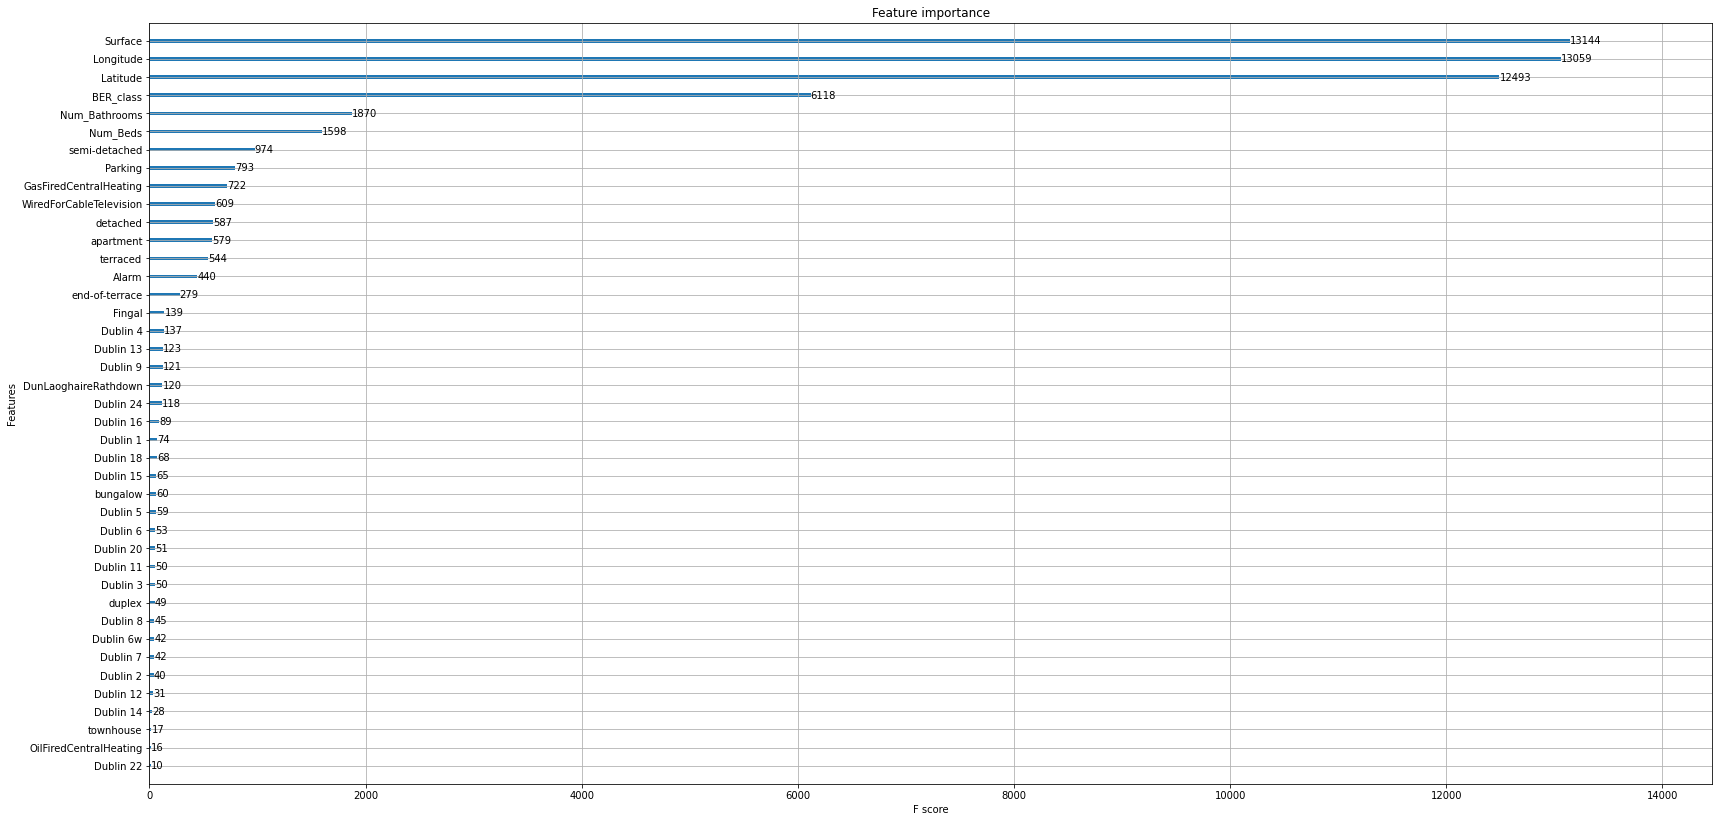

In [184]:
# Feature selection using XGBoost[1]
from xgboost import XGBClassifier
from xgboost import plot_importance

#Remove Categorical Variables
house_train_fi = house_train.drop(['Index','Description', 'Features'], axis=1)
# For train/test split
X = house_train_fi.drop('Price',axis=1)
y = house_train_fi['Price']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)
fi_Model = XGBClassifier()
fi_Model.fit(X_train, y_train)
# plot feature importance
plt.rcParams["figure.figsize"] = (28, 14)
plot_importance(fi_Model)
plt.show();

Feature Importance based on XGBoost tell us that surface, latitude, longitude and BER class are the top most important features to predict the property prices, followed by number of beds and number of bathrooms, that interesting enough were the two features with high correlation against price. As extra features we have semi-detached type of property and parking and gas fired central heating for services in importance.

# MODEL

## Baseline Model

In [185]:
X = house_train[['Surface','Latitude','Longitude','BER_class','Num_Beds','Num_Bathrooms','semi-detached','Parking','GasFiredCentralHeating','terraced']]
X_ = house_test[['Surface','Latitude','Longitude','BER_class','Num_Beds','Num_Bathrooms','semi-detached','Parking','GasFiredCentralHeating','terraced']]
y = house_train["Price"]

In [186]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_ = scaler.fit_transform(X_)
y = scaler.fit_transform(y.values.reshape(-1,1))

In [187]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

lr = LinearRegression().fit(X, y)
print('LinearRegression Score:', lr.score(X, y))

y_pred = lr.predict(X)
y_pred = np.exp(scaler.inverse_transform(y_pred))
y = np.exp(scaler.inverse_transform(y))

print('LinearRegression MAE: ', mean_absolute_error(y, y_pred))
print('LinearRegression MSLE: ', mean_squared_log_error(y, y_pred))

LinearRegression Score: 0.7688136699755357
LinearRegression MAE:  137755.24728683903
LinearRegression MSLE:  0.08223065622707178


In [188]:
# Sample submission
y_pred_sub = lr.predict(X_)
y_pred_sub = np.exp(scaler.inverse_transform(y_pred_sub))
house_test['Price'] = y_pred_sub

initial_submission = pd.DataFrame(house_test['Price'])
initial_submission['Index'] = sample_submission['Index']
initial_submission = initial_submission[['Index', 'Price']]
initial_submission = initial_submission.reset_index(drop=True)
initial_submission.to_csv('sample_submission_v3.csv')
initial_submission

,Index,Price
0,1639,317405.743470
1,1640,492795.696146
2,1641,484799.207123
3,1642,835073.253695
4,1643,367894.845610
...,...,...
697,2336,235229.095595
698,2337,285670.540300
699,2338,504960.976742
700,2339,497853.856893


In [189]:
#files.download('sample_submission_v3.csv')

Baseline Model used was linear regression, that included some of the numerical variables present in the dataset such as: 'Surface','Latitude','Longitude','BER_class','Num_Beds','Num_Bathrooms','semi-detached','Parking','GasFiredCentralHeating','terraced'. Selected as they are the top 10 features, according to the feature importance XGBoost based algorithm. In this case, target column `Price` was log transformed.

## Piecewise Regression

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

### Full Model

In [191]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['Surface', 'Latitude','Longitude', 'BER_class', 'Num_Beds', 'Num_Bathrooms', 'semi-detached', 'Parking', 'GasFiredCentralHeating', 'terraced', 'Price']
# dropna: remove missing values
df_subset_train = house_train[featrain].dropna(axis=0)

featest = ['Surface', 'Latitude','Longitude', 'BER_class', 'Num_Beds', 'Num_Bathrooms', 'semi-detached', 'Parking', 'GasFiredCentralHeating', 'terraced']
# dropna: remove missing values
df_subset_test  =  house_test[featest].dropna(axis=0)

In [192]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [196]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, price
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_subset_train.Price[0:len(df_subset_test)].values

In [197]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [198]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 1,249.2


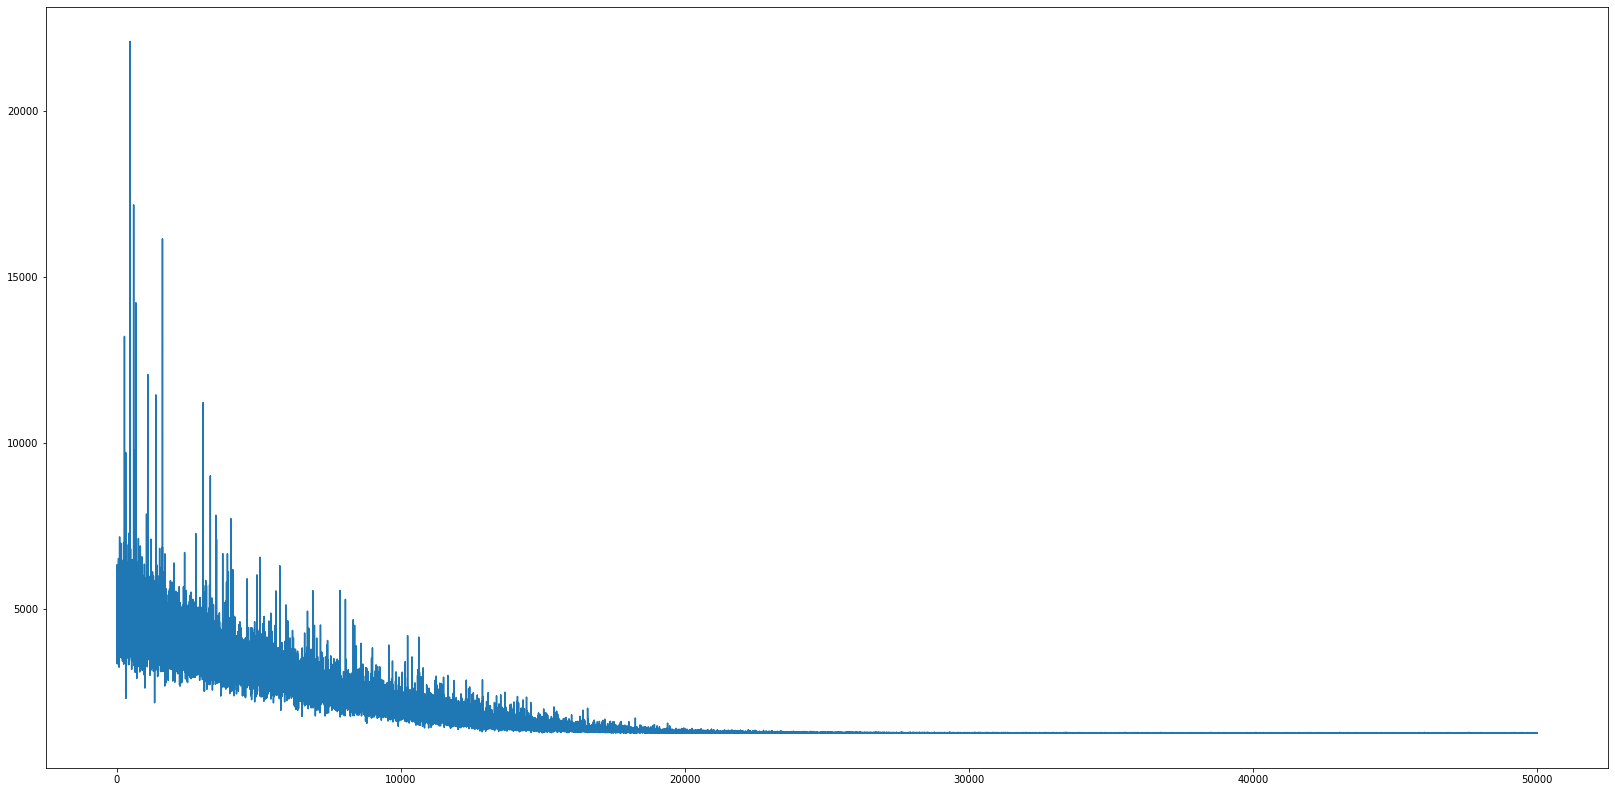

In [199]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [200]:
# samples from the posterior
posterior = approximation.sample(5000)

In [201]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  0.619397266446768
MAPE =  0.04739307716678649


In [206]:
y_pred_out = np.exp(yscaler.inverse_transform(y_pred_BLR))
results = house_test['Index']
BLR_results = pd.DataFrame(y_pred_BLR, columns=['Price'])
BLR = pd.concat([results, BLR_results], axis=1)
BLR.to_csv('sample_submission_v4.csv',index=False)

In [207]:
files.download('sample_submission_v4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Clustering

In [208]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

from sys import maxsize
from numpy import set_printoptions

16.00156183470237

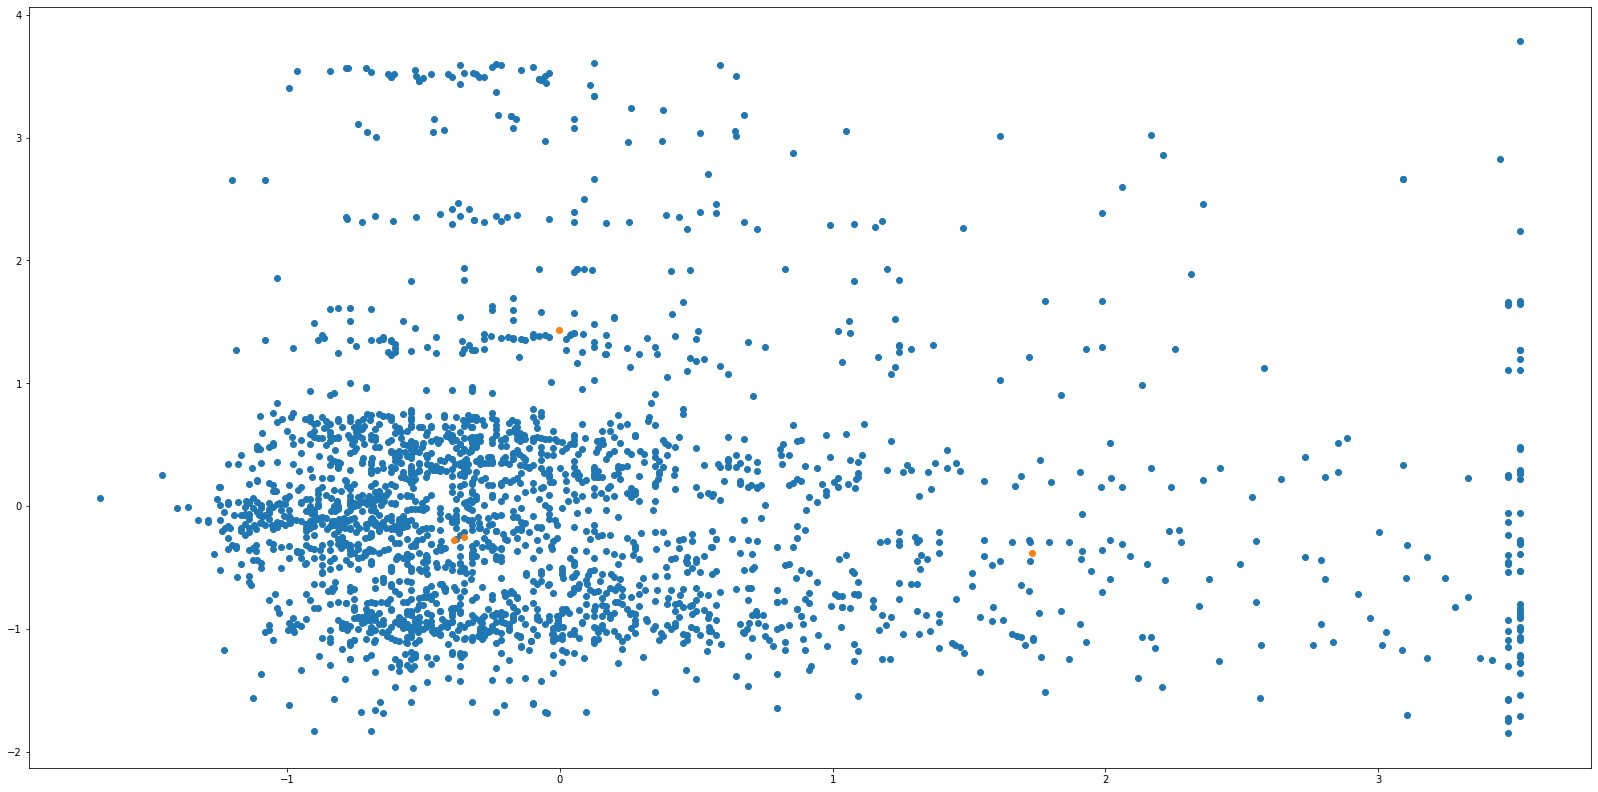

In [209]:
gmm = GaussianMixture(n_components=4)
# clustering by features 1 - 2
ind=[0,1,2]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])
# lenght of feature clustering
np.max(ys_train)

Clusters

In [210]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 216, 1: 849, 2: 319, 3: 253}

In [211]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 98, 1: 387, 2: 112, 3: 105}

In [212]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [213]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [214]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [215]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

In [215]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Piecewise Model

In [216]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 311.97


In [217]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 843.52


In [218]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 351.72


In [219]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 288.02


In [220]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

Simulations

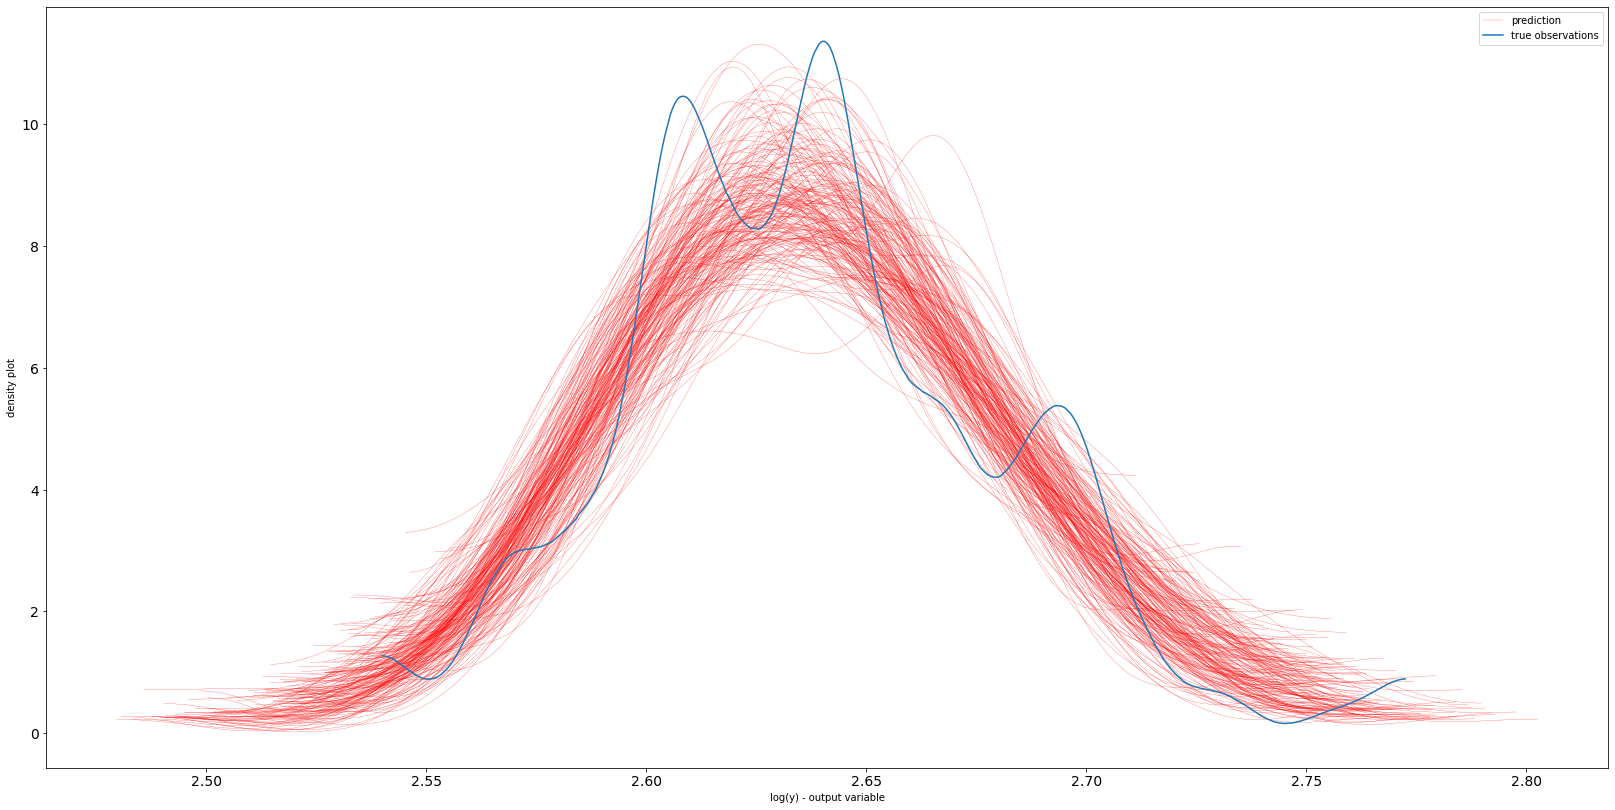

In [221]:
#Simulation: Only Cluster 0
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

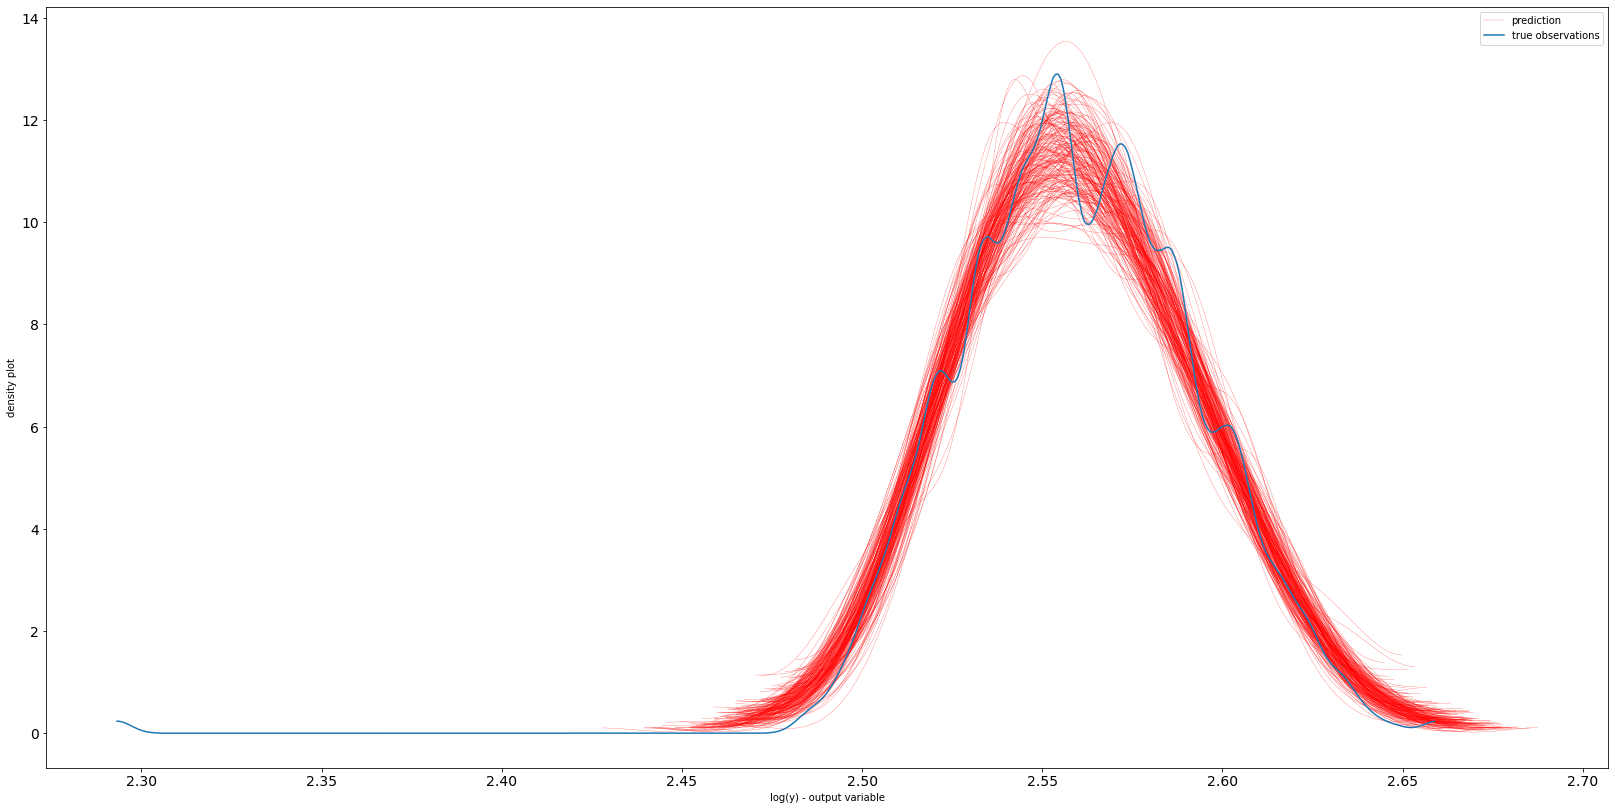

In [222]:
#Simulation: Only Cluster 1
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

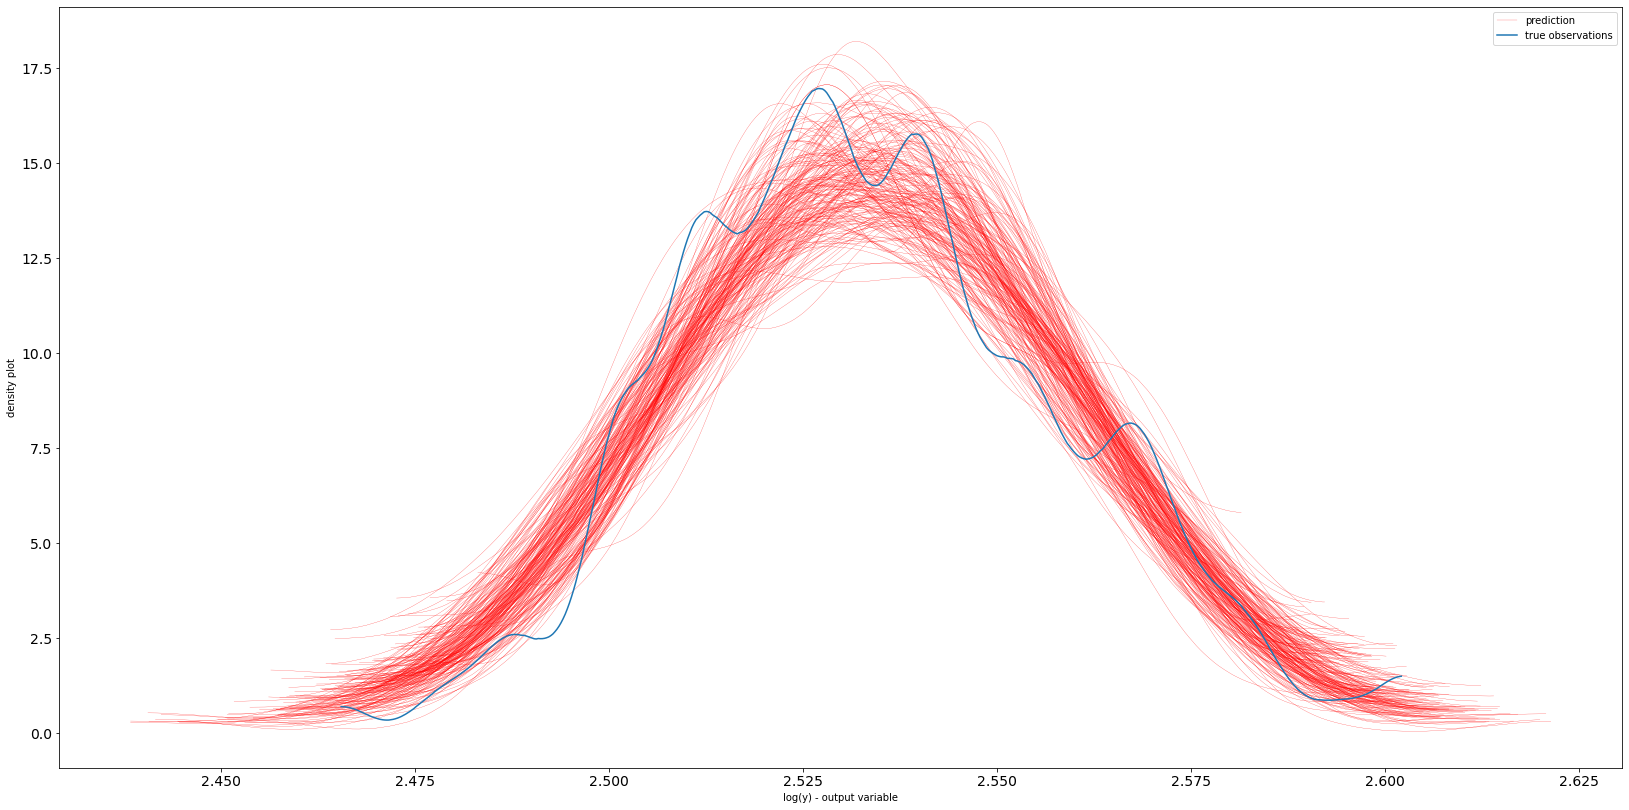

In [223]:
#Simulation: Only Cluster 2
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

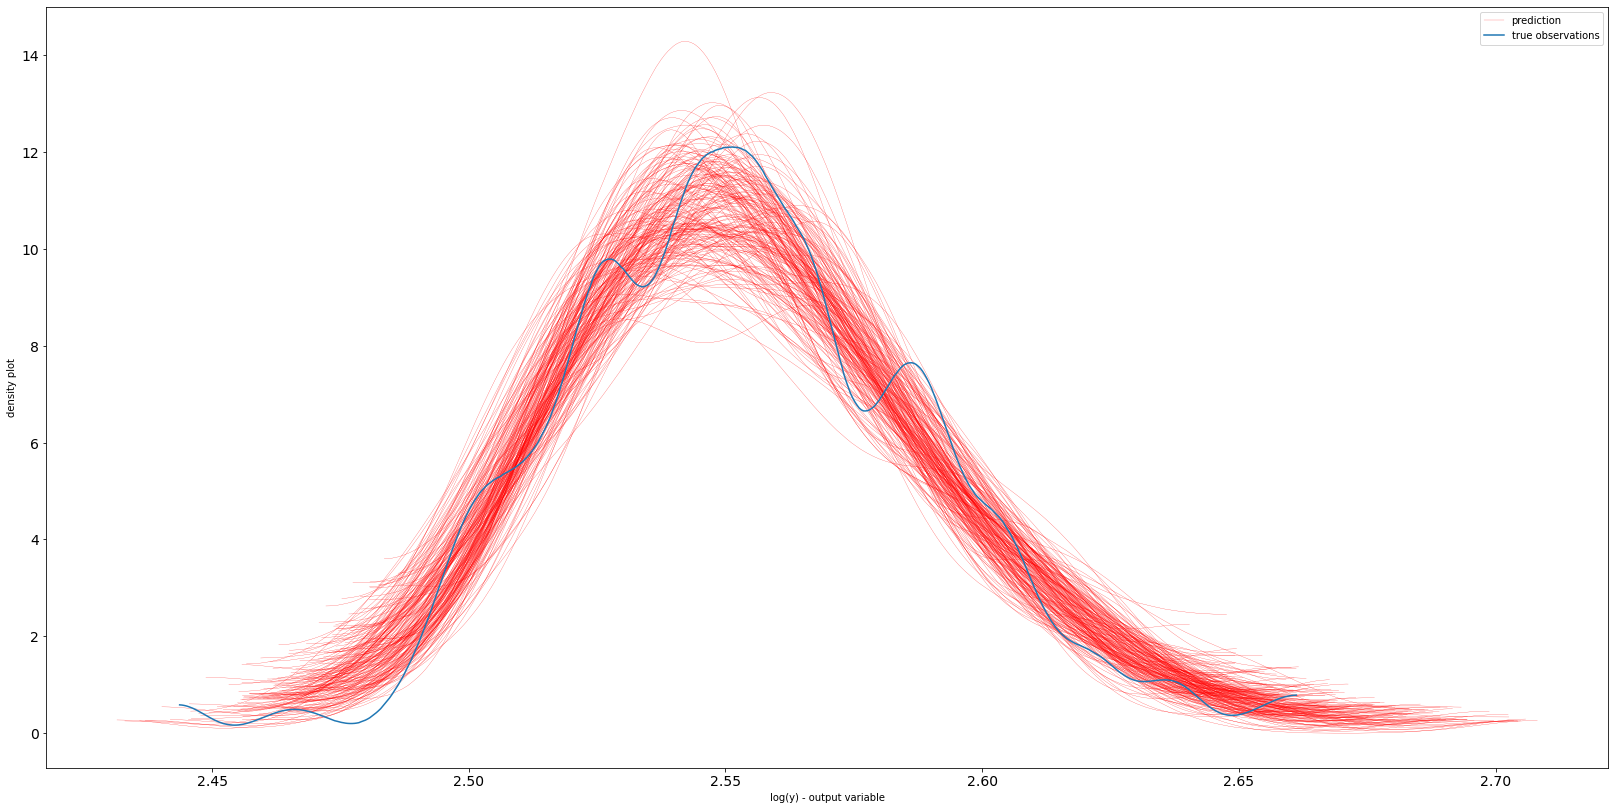

In [224]:
#Simulation: Only Cluster 3
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

Overall

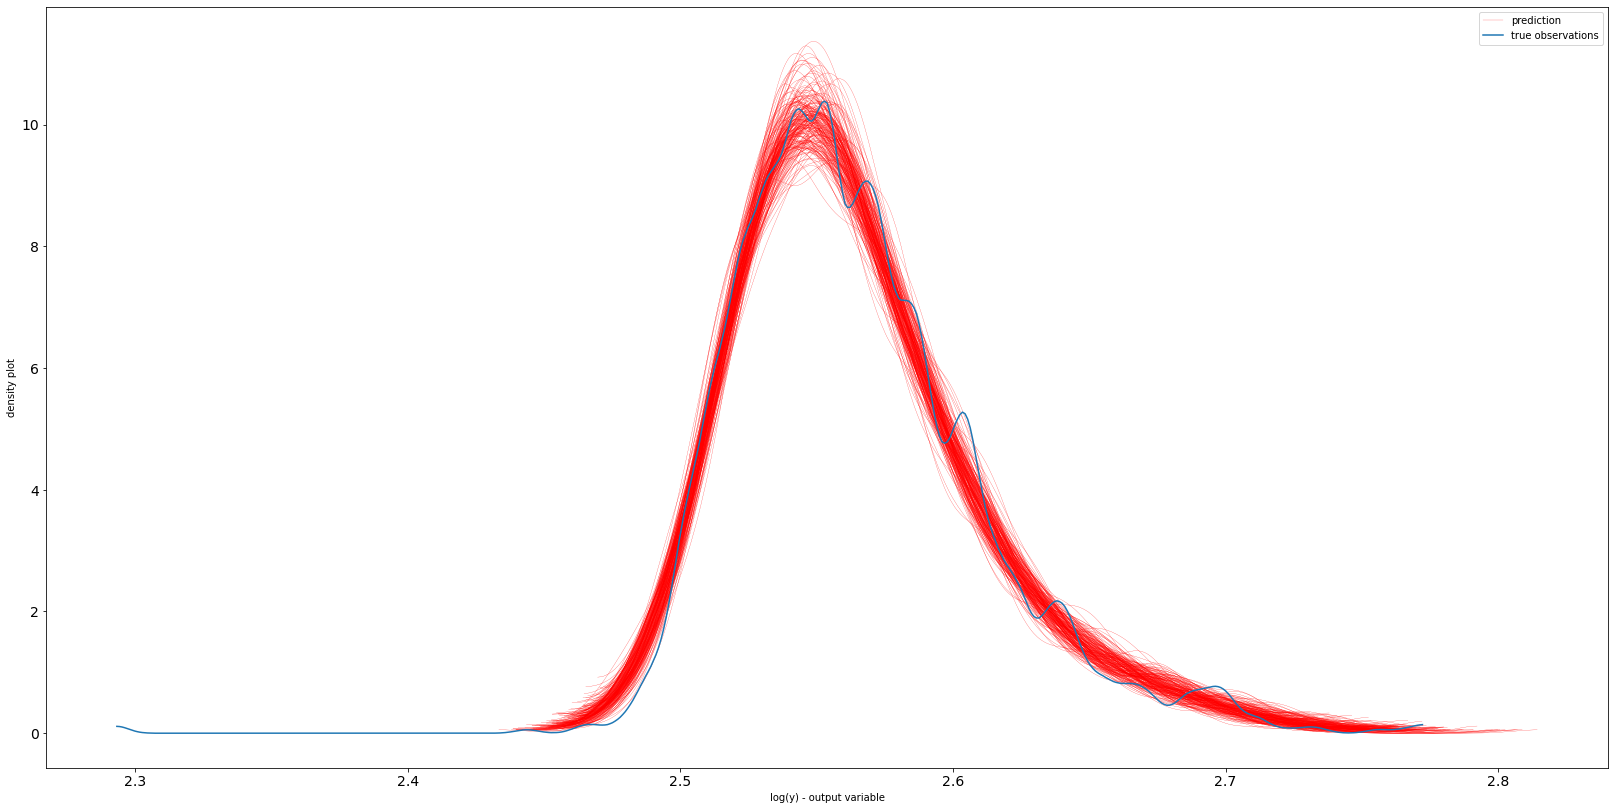

In [225]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                   yscaler1.inverse_transform(Ypred1),
                   yscaler2.inverse_transform(Ypred2),
                   yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

TestSet Performance

In [226]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster 0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster 1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster 2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster 3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 98 , MAE Cluster 0= 1.207854507431458
Size Cluster1 387 , MAE Cluster 1= 0.5340333044428704
Size Cluster2 112 , MAE Cluster 2= 0.5578105936100821
Size Cluster3 105 , MAE Cluster 3= 0.5360074019954719
MAE= 0.6321883108853668


In [232]:
results = house_test['Index']
piecewise_results = pd.DataFrame(joint, columns=['Price'])
piecewise = pd.concat([results, piecewise_results], axis=1)
piecewise.to_csv('sample_submission_piecewise_v5.csv',index=False)

In [231]:
files.download('sample_submission_piecewise_v5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PPC on the Test set

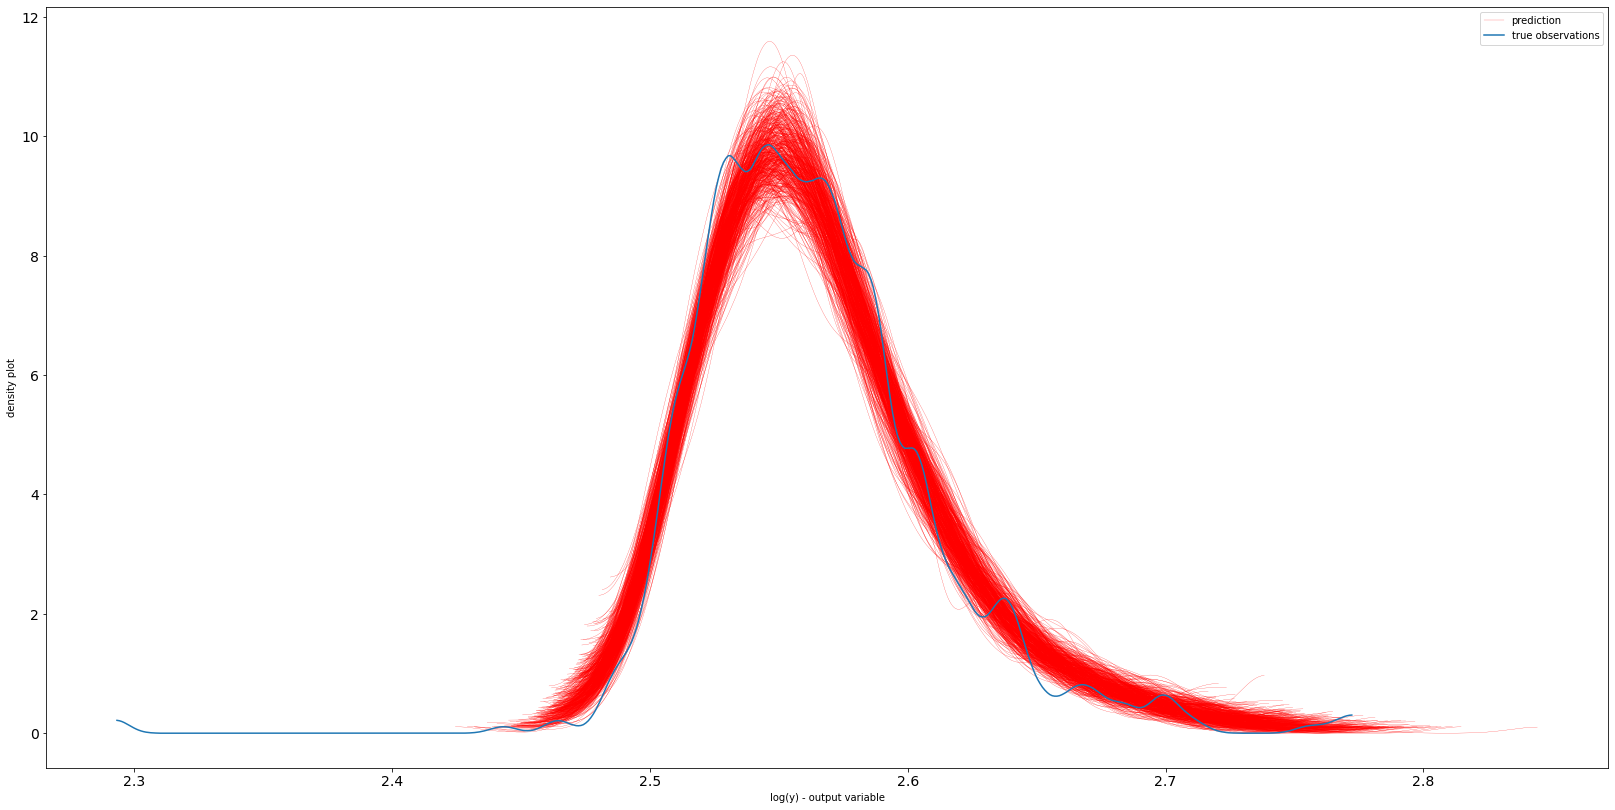

In [227]:
## Posterior predictive checks (PPCs)
num_samples2 = 500
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Bayesian NN

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

Your comments, explanation, and references here.

In [ ]:
# your code here

# SUMMARY

Your summary here.